# Notebook for comparision Bolidozor and trajectory data from optical systems



In [2]:
from MLABvo.Bolidozor import Bolidozor
#from MLABvo.Bolidozor import BolidozorTools
import json
import datetime
import numpy as np
import scipy
import scipy.signal
import scipy.constants
from scipy.optimize import minimize
from scipy.interpolate import interp1d, UnivariateSpline
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import dates
from mpl_toolkits.mplot3d.axes3d import Axes3D
import mpltools
import sys
from math import *

sys.path.append("..") 
import recviewer
import dateutil.parser
from Geocentric import Geocentric
geoC = Geocentric(6378137, 6356752.314)

%matplotlib inline 

# Inicializace bolidozoru

Funkce ```Bolidozor.getMultibolid``` jako jediný parametr bere id skupiny, které lze zjistit například zde: http://rtbolidozor.astro.cz/multibolid/

In [3]:
multibolid_id = 2047621


ZHR = 1

if True:#2057410
    multibolid_id = 2057410
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([44980.37638663])

    met_start_lat = np.array([48.340593635025])
    met_start_lon = np.array([6.572188010297])

    met_stop_lat = np.array([49.52717828089])
    met_stop_lon = np.array([6.763558272451])

    met_velocity = [32000]
    model_offset = 2.5
    
if True:#2047621
    multibolid_id = 2047621
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([41896.884619396])

    met_start_lat = np.array([49.997439391249])
    met_start_lon = np.array([9.692504979925])

    met_stop_lat = np.array([50.035327181108])
    met_stop_lon = np.array([7.560013628387])

    met_velocity = np.array([19000])
    
    
if True:#2017388
    multibolid_id = 2017388
    met_start_altitude = np.array([60000.0])
    met_stop_altitude = np.array([8910.7633450924])

    met_stop_lon = np.array([6.512636353428])
    met_stop_lat = np.array([51.944553218498])
    
    met_start_lon = np.array([9.996094184309])
    met_start_lat = np.array([51.230870109095])
    
    met_velocity = np.array([19000])
    
    
stations = {}
#stations.append({'name': 'Zebrak','latitude':49.8736, 'longitude':13.8986,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'uFlu','latitude':50.0795, 'longitude':14.4891,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'OBSUPICE','latitude':50.5067,'longitude':16.0115,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations['SVAKOV-R12']={'name': 'SVAKOV','latitude':49.2607,'longitude':14.6917,'elevation':400, 'status': 'operational', 'type': 'receiver'}
#stations.append({'name': 'ZVPP','latitude':48.9869,'longitude':14.4675,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'BPB','latitude':48.653153,'longitude':17.537413,'elevation':400, 'status': 'testing', 'type': 'receiver'})
#stations.append({'name': 'HPHK','latitude':50.1772,'longitude':15.8386,'elevation':400, 'status': 'testing', 'type': 'receiver'})
#stations.append({'name': 'OBSJAROMER','latitude':50.351397,'longitude':15.915878,'elevation':400, 'status': 'testing', 'type': 'receiver'})
stations['HFN-R1']={'name': 'JHRADEC','latitude':49.1314,'longitude': 14.9999,'elevation':400, 'status': 'operational', 'type': 'receiver'}
stations['VALMEZ-R1']={'name': 'VALMEZ','latitude':49.463038,'longitude': 17.973544,'elevation':400, 'status': 'testing', 'type': 'receiver'}
#stations.append({'name': 'NACHODSKO','latitude':50.409407,'longitude':15.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'GERM1','latitude':50.409407,'longitude':10.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'GERM2','latitude':50.009407,'longitude':9.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'IT1','latitude':45.409407,'longitude':10.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations['DDMTREBIC-R3']={'name': 'TREBIC','latitude':49.2071,'longitude':15.8759,'elevation':480, 'status': 'operational', 'type': 'receiver'}


c = scipy.constants.c
f0 = 143050000
trans_station_point = np.array(geoC.GeographicToGeocentric(47.347993, 5.515079, 190))
t = 0.005
timesteps = np.arange(-20,10,t)

In [4]:
bz = Bolidozor()
bolids = bz.getMultibolid(id=multibolid_id)
print('Počet detekcí ve skupině je',len(bolids.result))

{'datetime_start': '2017-12-03 20:42:33.366604', 'api_version': '0.0.2', 'api_url': 'http://api.vo.astro.cz/bolidozor/', 'job_id': '5dd18942-ccb6-4103-8b40-27e9a47b41f4', 'job_result_url': 'http://api.vo.astro.cz/bolidozor/job/5dd18942-ccb6-4103-8b40-27e9a47b41f4', 'job_state': 'PENDING'}
Počet detekcí ve skupině je 3


Získaná data z MLABvo jsou k dispozici v ```Bolidozor.getMultibolid.result```.

Následující buňka ukazuje, jak lze procházet záznamy po jednom.

**Výsledek obsahuje následující informace**

In [5]:
print(list(bolids.result[0].keys()))
print("")
print(bolids.result[0])

['id_observer', 'url_file_raw', 'magnitude', 'event_id', 'namesimple', 'peak_f', 'url_file', 'url_file_js9', 'id_server', 'duration', 'noise', 'station_name', 'file_status', 'filename', 'observatory_name', 'url_station', 'obstime', 'observatory_namesimple', 'filename_raw', 'filepath']

{'id_observer': 29, 'url_file_raw': 'http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_raws.fits', 'magnitude': 9.46616, 'event_id': 14822459, 'namesimple': 'SVAKOV-R12', 'peak_f': 26472.7, 'url_file': 'http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_met.fits', 'url_file_js9': 'http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_met.fits', 'id_server': 1, 'duration': 11.264, 'noise': 1.70533, 'station_name': 'SVAKOV-R12', 'file_status': 'online', 'filename': '20171111180241253_SVAKOV-R12_met.fits', 'observatory_name': 'Svák

Nahrát data do cache

In [6]:
for i, bolid in enumerate(bolids.result):
    print(i+1,'z',len(bolids.result))
    fits.open(bolid['url_file_raw'])

1 z 3
2 z 3
3 z 3


# Kalibrace času

tato funkce projde RAW soubory a snaží se v nich vyhledat GPS značku. 

Výstupem této funkce je ```dictionary```, který obsahuje informace o času na začátku souboru, času konce souboru a prvního vzorku s GPS značkou ze systémového času stanice. Tyto samé časy vrací taktéž oproti GPS času.


In [7]:
def getMeteorAround(station, time, distance = datetime.timedelta(minutes=600)):
    try:
        b = Bolidozor(debug = False)
        print(station, b.setStation(station))

        meteors = b.getMeteor(date_from=time-distance, date_to=time+distance, min_duration=1).result
        #if len(meteors) > 0:
            #for met in meteors:
            #    print(met['url_file_raw'], met['duration'], met['obstime'])
    
        return meteors
    except Exception as e:
        print('getMeteorAround', e)
        return False

Tato smyčka projde všechny soubory a použije na nich funkci pro kalibraci času. Výstup přidá do původní proměnné pod klíčem ```time_calib```.

Pokud je zapnuté debugování, tak ze skriptu vypadávají tato data:

delka zaznamu          : Délka záznamu
cas prvni vzorku s GPS : 
cas 1. GPS a konec     : Vzdálenost první detekované GPS ke konci souboru
SysCas ukladani souboru: Čas z hlavičky FITSu ['DATE']
SysCas zacatku souboru : Čas z hlavičky ['DATE'] mínus délka souboru
SysCas 1. GPS znacky   : Systémový čas stanice v okamžiku GPS značky
Korekce systémoveho čas: Systémový čas 
CorCas ukladani souboru: 2017-09-23 07:24:19.241618 s
CorCas zacatku souboru : 2017-09-23 07:24:06.241614
CorCas 1. GPS znacky   : 2017-09-23 07:24:10

In [8]:
np.set_printoptions(suppress=True)

def samp2time(sample):
    return sample/96000
def time2samp(time):
    return time*2*96000
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='full')
    return y_smooth

def timeCalibration(raw_file, station=None, sigma = 10, debug = True, browse_around = True):
    calibration_data = {}
    calibration_data['samp_correction'] = 0
    # Stahnout a otevrit RAW fits meteoru
    hdulist = fits.open(raw_file, cache=True)
    met_data = np.abs(np.ravel(hdulist[0].data))
    met_smooth = smooth(met_data, 25)
    clip_val = np.std(met_data)*sigma

    
    #file_length = hdulist[0].header['NAXIS2']*hdulist[0].header['CDELT2']/1000.0
    file_length = samp2time(hdulist[0].header['NAXIS2'])
    DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
    DATE = datetime.datetime.strptime(hdulist[0].header['DATE'], "%Y-%m-%dT%H:%M:%S" )
    calibration_data['sys_file_beg'] = DATE-datetime.timedelta(seconds=file_length)
    calibration_data['sys_file_end'] = DATE
    
    if debug: plt.axhline(y=clip_val, color='red')
    max_val = np.max(met_data)
    time_firstGPS = None
    ten_sec = []
        
    # Tato cast hleda v datech GPS znacky
    # Kdyz je najde, zapise je do seznamu `ten_sec`
    # Prvni GPS znacku to ulozi jako float do `time_firstGPS`
    
    for i, point in enumerate(met_smooth):
        if point > clip_val:
            if not time_firstGPS:
                 time_firstGPS = samp2time(i/2)
                 if debug: 
                    plt.axvline(x=time2samp(time_firstGPS), color='red', lw=2)
                    plt.axvline(x=time2samp(time_firstGPS)+time2samp(10), color='green', lw=2)
            ten_sec.append(samp2time(i/2))
    
    # Ohodnotit kvalitu dat,
        #  100 - Velmi dobre - jasna GPS znacka,
        #  50  - Znacka není - najdeme ji v jiném souboru a zarovnáme podle vzorků zvukovky
        #  0  - Data jsou nekvalitni, nelze je pouzivat
    
    if time_firstGPS:
        calibration_data['quality'] = 100
        calibration_data['method'] = 'GPS'
        gps = (DATE-datetime.timedelta(seconds=file_length-time_firstGPS)).timestamp()
        correction = seconds=round(gps/10.0)*10.0-gps
    elif clip_val > 0.9:
        calibration_data['quality'] = 0
        calibration_data['method'] = 'Null'
        correction = .0
    else:
        calibration_data['quality'] = 50
        calibration_data['method'] = 'Around GPS'
        correction = .0
        
        # Kdyz je kvalita 50 (znacka neni v rozsahu zaznamu),
        #  tak se pokusi sehnat seznam okolnich meteoru,
        #  ve kterych najde GPS znacky
    
        if browse_around and station:
            time_offset = []
            if debug: print("hledam alternativni zdroj presneho casu")
            around = getMeteorAround(station, datetime.datetime.strptime(hdulist[0].header['DATE'], "%Y-%m-%dT%H:%M:%S" ))
            if around:
                print("Okolnich souboru:", len(around))
                for meteor in around:
                    meteor_data = timeCalibration(meteor['url_file_raw'], debug=False, browse_around = False)
                    if meteor_data['quality'] == 100:

                        time_offset.append([
                            meteor_data['CRVAL2'],
                            meteor_data['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp(),
                            meteor_data['samp_correction'],
                            #meteor_data['CRVAL2']-meteor_data['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()
                                            ])
                        print("+", end='')
                    else:
                        print("-", end='')
                        
                ## plt.plot(time_offset)
                #plt.show()
                #for ar in time_offset:
                #    print("%f %f %f" %(ar[0], ar[1], ar[2]))
                mean = np.mean(np.array(time_offset)[:,2])
                print("mean: %f, std: %f" %(mean, np.std(np.array(time_offset)[:,2])))
                calibration_data['samp_correction'] = mean
            else:
                print("## Nelze najit žádné daší meteory v okolí")
                calibration_data['method'] = 'Null'
                calibration_data['quality'] = 25
            
                    
    if not time_firstGPS: time_firstGPS = 0
    correction = datetime.timedelta(seconds=correction)
    
    calibration_data['CRVAL2'] = hdulist[0].header['CRVAL2']/1000.0
    calibration_data['DATE-OBS'] = DATE_OBS
    
    calibration_data['sys_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    calibration_data['sys_error'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)
    
    calibration_data['cor_file_beg'] = DATE-datetime.timedelta(seconds=file_length)+correction
    calibration_data['cor_file_end'] = DATE+correction
    calibration_data['cor_1st_GPS'] = DATE-datetime.timedelta(seconds=file_length-time_firstGPS)+correction
    
    calibration_data['sys_correction'] = correction
    if calibration_data['samp_correction'] == 0:
        calibration_data['samp_correction'] = calibration_data['CRVAL2']-calibration_data['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()
    else:
        calibration_data['cor_file_beg'] = datetime.datetime.utcfromtimestamp(calibration_data['CRVAL2'])-datetime.timedelta(seconds=calibration_data['samp_correction'])
        calibration_data['cor_file_end'] = datetime.datetime.utcfromtimestamp(calibration_data['CRVAL2'])-datetime.timedelta(seconds=calibration_data['samp_correction']-file_length)
        calibration_data['cor_1st_GPS'] = datetime.datetime.utcfromtimestamp(calibration_data['CRVAL2'])-datetime.timedelta(seconds=calibration_data['samp_correction'])
    
    if debug:
        #DATE_OBS = datetime.datetime.strptime(hdulist[0].header['DATE-OBS'], "%Y-%m-%dT%H:%M:%S" )
        print("Zpracovavam soubor:", raw_file)
        print('delka zaznamu          :', file_length, "s")
        print('cas prvni. vzorku s GPS:', time_firstGPS, "s")
        print('cas 1. GPS a konec     :', file_length - time_firstGPS, "s")
        print('SysCas ukladani souboru:', calibration_data['sys_file_end'], "s")
        print('SysCas zacatku souboru :', calibration_data['sys_file_beg'])
        print('SysCas 1. GPS znacky   :', calibration_data['sys_1st_GPS'])
        print('Korekce systémoveho čas:', calibration_data['sys_correction'])
        print('Korekce času zvukovky  :', calibration_data['samp_correction'])
        print('CorCas ukladani souboru:', calibration_data['cor_file_end'], "s")
        print('CorCas zacatku souboru :', calibration_data['cor_file_beg'])
        print('CorCas 1. GPS znacky   :', calibration_data['cor_1st_GPS'])
        print('Kvalita souboru        :', calibration_data['quality'])
        print('Počet vzorků s gps znač:', len(ten_sec))
        plt.plot(met_data, lw=0.5)
        plt.plot(met_smooth)
        plt.show()
    return calibration_data
        

0 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/svakov/SVAKOV-R12/meteors/2017/11/11/18/20171111180241253_SVAKOV-R12_raws.fits
delka zaznamu          : 17.6 s
cas prvni. vzorku s GPS: 6.144442708333333 s
cas 1. GPS a konec     : 11.455557291666668 s
SysCas ukladani souboru: 2017-11-11 18:02:09 s
SysCas zacatku souboru : 2017-11-11 18:01:51.400000
SysCas 1. GPS znacky   : 2017-11-11 18:01:57.544443
Korekce systémoveho čas: 0:00:02.455557
Korekce času zvukovky  : 47.39744305610657
CorCas ukladani souboru: 2017-11-11 18:02:11.455557 s
CorCas zacatku souboru : 2017-11-11 18:01:53.855557
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Počet vzorků s gps znač: 5899


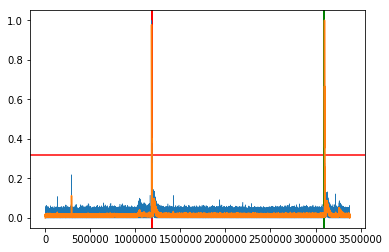

1 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/11/11/18/20171111180205537_DDMTREBIC-R3_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/ddmtrebic/DDMTREBIC-R3/meteors/2017/11/11/18/20171111180205537_DDMTREBIC-R3_raws.fits
delka zaznamu          : 13.4 s
cas prvni. vzorku s GPS: 5.914046875 s
cas 1. GPS a konec     : 7.485953125 s
SysCas ukladani souboru: 2017-11-11 18:02:06 s
SysCas zacatku souboru : 2017-11-11 18:01:52.600000
SysCas 1. GPS znacky   : 2017-11-11 18:01:58.514047
Korekce systémoveho čas: 0:00:01.485953
Korekce času zvukovky  : 11.45104694366455
CorCas ukladani souboru: 2017-11-11 18:02:07.485953 s
CorCas zacatku souboru : 2017-11-11 18:01:54.085953
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Počet vzorků s gps znač: 2504


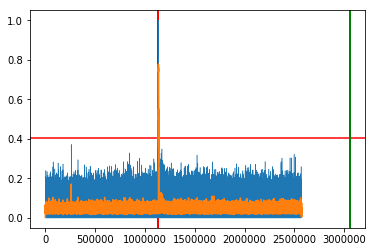

2 ==================================
snapshot: http://space.astro.cz/bolidozor/support/js9browser/#/bolidozor/HFN/HFN-R1/meteors/2017/11/11/18/20171111180154354_HFN-R1_met.fits
Zpracovavam soubor: http://space.astro.cz/bolidozor/HFN/HFN-R1/meteors/2017/11/11/18/20171111180154354_HFN-R1_raws.fits
delka zaznamu          : 18.399989583333333 s
cas prvni. vzorku s GPS: 5.8105416666666665 s
cas 1. GPS a konec     : 12.589447916666668 s
SysCas ukladani souboru: 2017-11-11 18:02:11 s
SysCas zacatku souboru : 2017-11-11 18:01:52.600010
SysCas 1. GPS znacky   : 2017-11-11 18:01:58.410552
Korekce systémoveho čas: 0:00:01.589448
Korekce času zvukovky  : 0.16454219818115234
CorCas ukladani souboru: 2017-11-11 18:02:12.589448 s
CorCas zacatku souboru : 2017-11-11 18:01:54.189458
CorCas 1. GPS znacky   : 2017-11-11 18:02:00
Kvalita souboru        : 100
Počet vzorků s gps znač: 11413


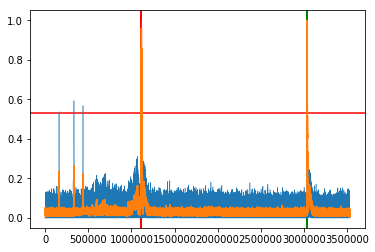

In [9]:

%matplotlib inline
for i, bolid in enumerate(bolids.result):
    try:
        print(i,"==================================")
        print("snapshot:", bolid['url_file_js9'])
        bolids.result[i]['time_calib']=timeCalibration(bolid['url_file_raw'], bolid['station_name'])
    except Exception as e:
        print("for bolids.result:", e)
    

# Filtr nevyhovujících dat

Protože v některých datech nemusí být dobře detekovatelná GPS značka, je zde možné tyto soubory ručně vyřadit. A to tím, že odkomentujete druhý řádek následující buňky a do seznamu napíšete čísla vyhovujících RAW souborů. (Jsou k nalezení ve výstupu předchozí buňky)

In [10]:
time_offset = {}
selected = list(range(0, len(bolids.result)))     # vyber vsech dat

#selected.remove(0)
#selected.remove(1)
#selected.remove(4)
#selected = [0,1,2,3,6]

#selected = [3,4,5,6]     #Pokud chcete vybrat konkrétní data, 
                               #odkomentujte tento řádek a vložte do něj čísla požadovaných dat

# time_offset[0] = +0   ## Posun času na stanici.
                        # Timto posunete data pro určitou stanici (podle indexu souboru)
                        # o určitý počet časových značek (10s intervalů)
                        # Kladné číslo posune graf 'nahoru" 
#time_offset[3]=0.5
#time_offset[4]=0.5
#time_offset[0]=1

for i, bolid in enumerate(bolids.result):
    if bolid['time_calib']['quality'] < 50:
        selected.remove(i)
    if i in selected:
        print(i, bolid['time_calib']['quality'], 'sysT of gps:', bolid['time_calib']['cor_1st_GPS'], ',offset:', bolid['time_calib']['sys_correction'], bolid['filename'])

0 100 sysT of gps: 2017-11-11 18:02:00 ,offset: 0:00:02.455557 20171111180241253_SVAKOV-R12_met.fits
1 100 sysT of gps: 2017-11-11 18:02:00 ,offset: 0:00:01.485953 20171111180205537_DDMTREBIC-R3_met.fits
2 100 sysT of gps: 2017-11-11 18:02:00 ,offset: 0:00:01.589448 20171111180154354_HFN-R1_met.fits


# Zarovnané soubory

Toto je první buňka, jejíž výstup obsahuje časově zarovnané grafy. Pomocí proměnné ```gps_calib``` můžete nastavit, zdali Vaše zarovnání bude oproti absolutním GPS značkám (```gps_calib=True```) nebo oproti systémovému času stanic (```gps_calib=False```).

Using matplotlib backend: TkAgg
0 2017-11-11 18:01:53.855557
x and y must have same first dimension, but have shapes (3379200,) and (3379201,)
1 2017-11-11 18:01:54.085953
2 2017-11-11 18:01:54.189458
1510423313.855557 1510423332.589448


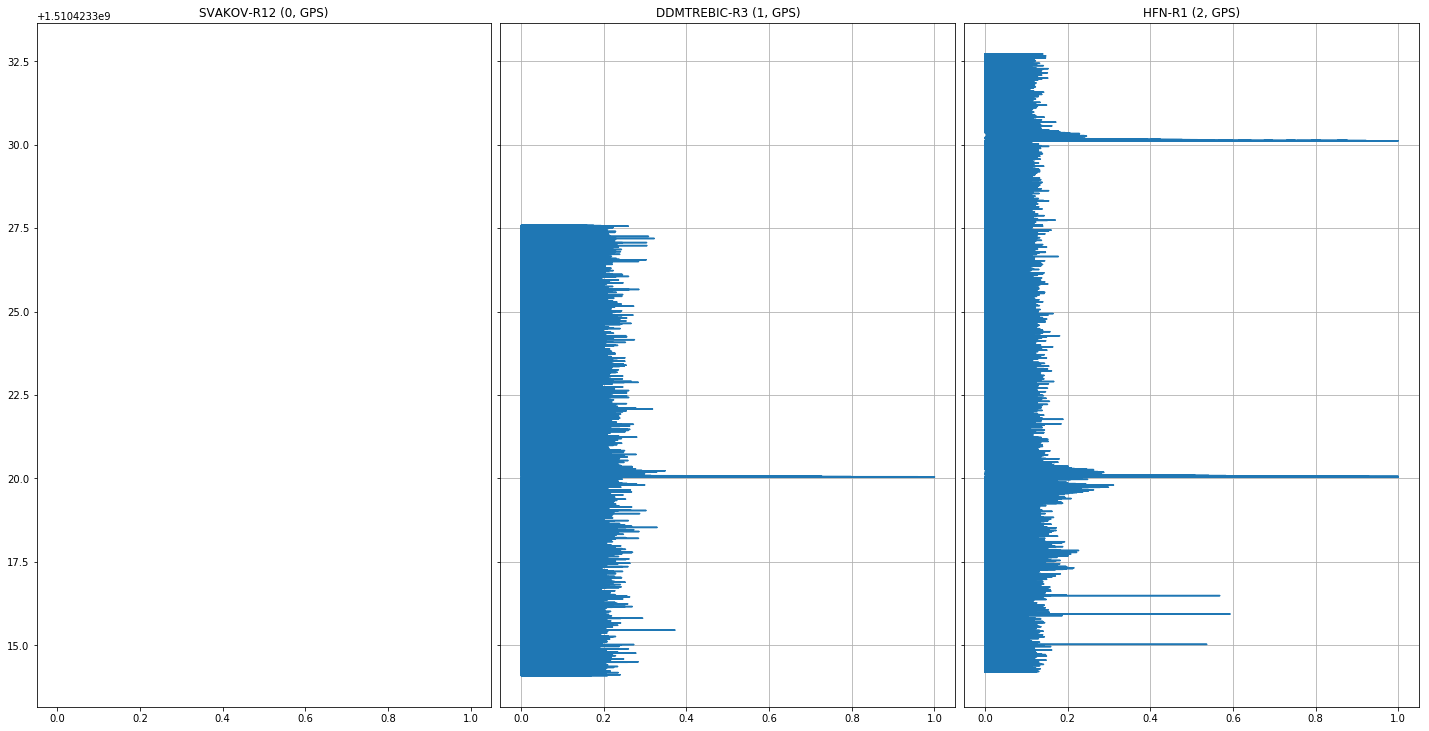

In [11]:
%matplotlib 
count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

gps_calib = True
minimal_time = None
maximal_time = None

for i, ax in enumerate(axis):
    try:
        bolid = bolids.result[selected[i]]
        print (i, bolid['time_calib']['cor_file_beg'])
        hdulist = fits.open(bolid['url_file_raw'])
        met_data = np.abs(np.ravel(hdulist[0].data))

        T_offset = 10*time_offset.get(selected[i], 0)

        if gps_calib:
            ax.set_title(bolid['namesimple'] + " (%s, %s)"%(selected[i], bolid['time_calib']['method']))
            min_date = bolid['time_calib']['cor_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['cor_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        else:
            ax.set_title(bolid['namesimple'] + " (" + str(selected[i])+") SYS-T")
            min_date = bolid['time_calib']['sys_file_beg'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
            max_date = bolid['time_calib']['sys_file_end'].replace(tzinfo=datetime.timezone.utc).timestamp()+T_offset
        array = np.arange(min_date, max_date, (max_date-min_date)/(len(met_data)))

        if not minimal_time: minimal_time = min_date
        if not maximal_time: maximal_time = max_date
        if min_date < minimal_time: minimal_time = min_date
        if max_date > maximal_time: maximal_time = max_date

        ax.plot(met_data, array)
        ax.grid(True)
    except Exception as e:
        print(e)

fig.subplots_adjust(wspace=0.02, left = 0.02, right=0.98,bottom=0.02, top=0.97)
print(minimal_time, maximal_time)
plt.show()

In [12]:
def waterfall(signal, sample_rate=None, bins = 4096 ):
    waterfall = recviewer.waterfallize(signal, bins)
    waterfall[np.isneginf(waterfall)] = np.nan
    wmin, wmax = np.nanmin(waterfall), np.nanmax(waterfall)
    return waterfall
slope = {}

** Next block is optional

In [13]:
'''
slope={
    'SVAKOV-R12':{
        'offset': 2.3,    # [s]
        'slope': 210   # [Hz/s]
    },
    'HFN-R1':{
        'offset': 1.2,    # [s]
        'slope': 290   # [Hz/s]
    }
}'''

"\nslope={\n    'SVAKOV-R12':{\n        'offset': 2.3,    # [s]\n        'slope': 210   # [Hz/s]\n    },\n    'HFN-R1':{\n        'offset': 1.2,    # [s]\n        'slope': 290   # [Hz/s]\n    }\n}"

In [14]:
def estimate_dopplers(trajectory, timesteps, f0, trans_station, rec_station):
    '''
        Returns array of dopplers for given transmitter to receiver position and defined frequency and known trajectory.
    '''
    rec_to_met = np.empty([trajectory.shape[0], 1])
    trans_to_met = np.empty([trajectory.shape[0], 1])
    doppler = np.empty([trajectory.shape[0], 2])
    
    previous_rec_to_met = np.linalg.norm(rec_station - trajectory[0])
    previous_trans_to_met = np.linalg.norm(trans_station - trajectory[0])
    
    t = timesteps[1] - timesteps[0]
    
    for i in range(trajectory.shape[0]):
        rec_to_met[i] = np.linalg.norm(rec_station - trajectory[i])
        trans_to_met[i] = np.linalg.norm(trans_station - trajectory[i])
    
        met_trans_speed = previous_trans_to_met - trans_to_met[i]
        previous_trans_to_met = trans_to_met[i]
        speed = met_trans_speed/t    
        f1 = ((c + speed)/c * f0)
                
        met_rec_speed = previous_rec_to_met - rec_to_met[i]    ## calculate bistatic velocity from known position
        previous_rec_to_met = rec_to_met[i]
        speed = met_rec_speed/t
        f2 = (c/(c - speed) * f1)
        doppler[i] = np.array([timesteps[i], f2-f0])
    return doppler


In [26]:
##### %matplotlib inline 
#%matplotlib notebook
%matplotlib tk
#from matplotlib import interactive
#interactive(False)


count = len(selected)
fig, axis = plt.subplots(1, count, sharex=True, sharey=True, figsize=(20, 10))

meteor_dopplers = [1,2]
met_points = np.empty([timesteps.size, 3])
met_velocity = [28000]
model_offset = 10

for meteor in range(len(met_start_altitude)):
    # get meteor vector from start and stop point
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[meteor], met_start_lon[meteor], met_start_altitude[meteor]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[meteor], met_stop_lon[meteor], met_stop_altitude[meteor]))
    met_vect = met_stop_point - met_start_point
    print(met_vect)
    
    for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
        met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[meteor]))
    print("generation of points DONE")

    print(time_offset)
    fig.suptitle("Multibolid %s (%s), velocity: %s" %(datetime.datetime.utcfromtimestamp(minimal_time).date(), multibolid_id, met_velocity))
    fig.subplots_adjust(hspace=0)
    plt.set_cmap('hot')
    for i, ax in enumerate(axis):
        print(selected[i])
        bolid = bolids.result[selected[i]]
        
        hdu = fits.open(bolid['url_file_raw'])[0]
        flat_data = np.ravel(hdu.data)

        T_offset = datetime.timedelta(seconds = 10*time_offset.get(selected[i], 0))
        #print(i, selected[i], bolid['time_calib']['cor_file_beg'], bolid['time_calib']['cor_file_beg']+T_offset, T_offset)
        d1 = bolid['time_calib']['cor_file_beg']+T_offset
        fds1 = dates.date2num(d1) # converted
        d2 = d1 + datetime.timedelta(seconds=hdu.header['NAXIS2']/96000)
        fds2 = dates.date2num(d2)
        print(fds1, fds2, fds2-fds1)
        

        ## optical doppler
        #for station in stations:
        rec_station_point = np.array(geoC.GeographicToGeocentric(stations[bolid['namesimple']]['latitude'], 
                                                                 stations[bolid['namesimple']]['longitude'], stations[bolid['namesimple']]['elevation']))
        
        #doppler_t(met_points, timesteps, f0, trans_station_point, rec_station_point)
        doppler = estimate_dopplers(met_points, timesteps, f0, trans_station_point, rec_station_point)
            
        meteor_dopplers[meteor] = doppler
        dopp_time = np.vectorize(lambda x: dates.date2num(d1+datetime.timedelta(seconds=(x)+model_offset)))
        dopp_freq = np.vectorize(lambda x: ((x)+26500.0))
        ax.plot(dopp_freq(doppler[1:,1]), dopp_time(doppler[1:,0]), 'black')
        #print("..",type(doppler[1:,0]), scale(doppler[1:,0])
        
        # Bolidozor
        arr = waterfall(flat_data[0::2] + 1j * flat_data[1::2], None, bins = 4096*0.5)
        ax.imshow(arr,  interpolation='none', aspect='auto',  extent=[-48000, 48000, fds2, fds1])
        ax.grid(True)

        ax.set_xlim(13000*2,13500*2)
        ax.yaxis_date()
        date_format = md.DateFormatter('%H:%M:%S')
        ax.yaxis.set_major_formatter(date_format)
        fig.autofmt_xdate()
        ax.set_ylim( datetime.datetime.utcfromtimestamp(minimal_time), datetime.datetime.utcfromtimestamp(maximal_time))

        if bolid['namesimple'] in slope:
            dd0 = bolid['time_calib']['cor_file_beg']+T_offset+datetime.timedelta(seconds=slope[bolid['namesimple']]['offset'])
            print(dd0)
            fdd0 = dates.date2num(dd0) # converted
            ax.plot([13250], [fdd0], 'xb')
            ax.plot([13000, 13500], [fdd0, fdd0], 'black', alpha=0.4)

            d = bolid['time_calib']['cor_file_beg']+T_offset+datetime.timedelta(seconds=slope[bolid['namesimple']]['offset']+250/slope[bolid['namesimple']]['slope'])
            s1 = dates.date2num(d)
            d = bolid['time_calib']['cor_file_beg']+T_offset+datetime.timedelta(seconds=slope[bolid['namesimple']]['offset']-250/slope[bolid['namesimple']]['slope'])
            s2 = dates.date2num(d) # converted
            ax.plot([13000, 13500], [s1, s2], 'blue', alpha=0.4)

            ax.set_title(bolid['namesimple'] + " - " + str(dd0))
        else:
            ax.set_title(bolid['namesimple'])

    fig.subplots_adjust(wspace=0.04, left = 0.03, right=0.98, bottom=0.03, top=0.93)
    plt.savefig('output.png', dpi=300)
    
    plt.show()


[ -58432.3796241  -253712.85668823    9570.59181281]
generation of points DONE
{}
0
736644.7513177727 736644.7515214763 0.00020370364654809237
1
736644.7513204393 736644.7514755318 0.0001550925662741065
2
736644.7513216372 736644.7515346 0.00021296285558491945


In [223]:
export = 'multibolid_%s_%s.ipynb' %(multibolid_id, datetime.datetime.utcfromtimestamp(minimal_time).date())
print(export)
#%notebook $export

multibolid_2017388_2017-11-11.ipynb


# Tweet
Tato část odešle multibolid porovnání na twitter účet bolidozoru. https://twitter.com/bolidozor

V počítači je potřeba mít vytvořený konfigurační soubor s kódy pro přihlášení. Takový soubor musí vypadat takto

```
[twitter]
CONSUMER_KEY = consumer_key
CONSUMER_SECRET = consumer_secret
ACCESS_TOKEN_KEY = access_token_key
ACCESS_TOKEN_SECRET = access_token_secret
```

Pokud při uploadování se nenahraje obrázek kvůli TimeOutu, zkuste zmenšit DPI grafu.

In [ ]:
from TwitterAPI import TwitterAPI
import base64
import configparser
import time

parser = configparser.ConfigParser()
parser.read('/home/roman/bolidozor_access.ini')
CONSUMER_KEY = parser['twitter']['CONSUMER_KEY']
CONSUMER_SECRET = parser['twitter']['CONSUMER_SECRET']
ACCESS_TOKEN_KEY = parser['twitter']['ACCESS_TOKEN_KEY']
ACCESS_TOKEN_SECRET =parser['twitter']['ACCESS_TOKEN_SECRET']

file = open('output.png', 'rb')
data = base64.b64encode(file.read())

api = TwitterAPI(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET, auth_type='oAuth1')
media = api.request('media/upload', None, {'media_data':data})
print(media.status_code, media.text)
m_id = json.loads(media.text)['media_id']
print(m_id)

time.sleep(1)
status_text='''
Multibolid-event on %s (id:%s)
More details at http://rtbolidozor.astro.cz/multibolid/event/%s/
This tweet was uploaded from Multibolid-analyser
''' %(datetime.datetime.utcfromtimestamp(minimal_time).date(), multibolid_id, multibolid_id)

r = api.request('statuses/update', {'status':status_text, 'media_ids':m_id})
print(status_text)
print(r.status_code, r.text)


# Extract head-echo


In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='full')
    return y_smooth


%matplotlib inline 
#%matplotlib notebook
print('len', len(selected))

#print(time_offset)
#fig.suptitle("Multibolid %s (%s)" %(datetime.datetime.utcfromtimestamp(minimal_time).date(), multibolid_id))
#fig.subplots_adjust(hspace=0)
#plt.set_cmap('hot')

'''
head_lines = {
    #0:[(4,13350),(25,13250)]
    0:[[2,27],[13350,13250]],
    3:[[0,16],[13335,13250]],
    4:[[4,24],[13360,13250]],
    6:[[41,73],[13450,13250]]
}
'''

f = open("meteor_%s_%s_raw.obs"%(multibolid_id, datetime.datetime.utcfromtimestamp(minimal_time).date()), 'w')
f.write('#F %s\n' %datetime.datetime.utcfromtimestamp(minimal_time).date())
for i, meteor in enumerate(selected):
    f.write('\n')
    %matplotlib inline
    bolid = bolids.result[meteor]
    print(i, meteor, bolid['url_file_raw'])
    
    hdu = fits.open(bolid['url_file_raw'])[0]
    flat_data = np.ravel(hdu.data)
    
    bins = 4096*2
    arr = waterfall(flat_data[0::2] + 1j * flat_data[1::2], None, bins = bins*2)[:,bins:]
    min_crop = 4500
    max_crop = 3600
    file_length = samp2time(hdu.header['NAXIS2'])    
    step_time = file_length/(arr.shape[0])
        
    step_freq = 24000/bins
    min_freq = min_crop*step_freq
    max_freq = 24000 - max_crop*step_freq

    selection = arr[:,+min_crop:-max_crop]
    
    plt.imshow(selection, aspect='auto', extent=[min_freq, max_freq,
                                                 bolid['time_calib']['cor_file_end'].timestamp(),
                                                 bolid['time_calib']['cor_file_beg'].timestamp()])

    plt.show()
    
    peak = np.empty([0,2])
    for i, row in enumerate(selection):
        max_i = np.argmax(row)
        max_v = row[max_i]
        peak = np.concatenate((peak, [[bolid['time_calib']['cor_file_beg'].timestamp()+i*step_time, -13250+(min_crop+max_i)*step_freq]]))
        f.write("%i\t%f\t%f\n" %(meteor,
                                 #bolid['time_calib']['cor_file_beg']+datetime.timedelta(seconds=i*step_time),
                                 bolid['time_calib']['cor_file_beg'].timestamp()+i*step_time,
                                 -13250+(min_crop+max_i)*step_freq
                                )
                )
        #plt.plot(row)
        #plt.show()
        #plt.plot(row)
    #plt.show()
    
    #plt.plot(peak[:,0], peak[:,1])
    plt.plot(peak[:,0],peak[:,1], 'x')
    
    '''  Tato část slouží k hledani bodu headecha podle primek 'head_lines'
    head = np.empty([0,2])
    if meteor in head_lines:
        plt.plot(head_lines[meteor][0],head_lines[meteor][1])
        vector = (1, (head_lines[meteor][1][1]-head_lines[meteor][1][0])/(head_lines[meteor][0][1]-head_lines[meteor][0][0]))
        print(vector)
        for p in peak:
            if head_lines[meteor][0][0] <= p[0] <= head_lines[meteor][0][1]:
                #print(p)
                pos = (p[0]+1)*vector[0]
                d = (head_lines[meteor][1][0]+(pos+1)*vector[1]) - p[1]
                #print(pos, d, p[1])
                if abs(d) < 50:
                    head = np.concatenate((head, [[p[0], p[1]]]))
                
                #d = np.linalg.norm(np.cross(head_lines[meteor][0][1]-head_lines[meteor][0][0], head_lines[meteor][1][1]-head_lines[meteor][1][0]))/np.linalg.norm(p[1])
                #print(d)
        plt.plot(head[:,1], '*')
    '''
        
    plt.show()
    #print(peak)
f.close()

# Výběr head-echa

Nyní je potřeba otevřít soubor ```meteor_[id]_[date]_raw.obs``` a v něm odstanit (nebo zakomentovat '#') řádky, které neodpovídají head-echu. Následně je potřeba soubor uložit s názvem ```meteor_[id]_[date]_clean.obs```. Následující buňka vykreslí vybraná data.

In [ ]:
%matplotlib inline
#%matplotlib interactive
#import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,10)
try:
    f = open("meteor_%s_%s_clean.obs"%(multibolid_id, datetime.datetime.utcfromtimestamp(minimal_time).date()), 'r')
except Exception as e:
    print(e)
    f = open("meteor_%s_%s_raw.obs"%(multibolid_id, datetime.datetime.utcfromtimestamp(minimal_time).date()), 'r')

met_p = {}
for line in f.readlines():
    if ('#' not in line) and ('\t' in line):
        split = line.split('\t')
        if not split[0] in met_p: met_p[split[0]]={'time':[], 'value':[]}
        met_p[split[0]]['time'].append(float(split[1]))
        met_p[split[0]]['value'].append(float(split[2]))
#print(met_p)

for station in met_p:
    print(station)
    #print(station, met_p[station])
    plt.plot(met_p[station]['time'],met_p[station]['value'], 'o-')
plt.show()

In [ ]:
def init():
    from MLABvo.Bolidozor import Bolidozor
    #from MLABvo.Bolidozor import BolidozorTools
    import json
    import datetime
    import numpy as np
    import scipy.signal
    from astropy.io import fits
    import matplotlib.pyplot as plt
    import matplotlib.dates as md
    from matplotlib import dates
    import mpltools
    import sys
    sys.path.append("..") 
    import recviewer
    import dateutil.parser

    %matplotlib inline 

In [ ]:
init()